In [1]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from making_figures import calculate_diff

In [2]:
extent = (2000., 2000.)
shape = (200, 200)

x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))
p = dv.TimeFunction(name='p', grid=grid, space_order=4, time_order=2)

vp = 3
dt = np.amin(grid.spacing)*0.6/vp

t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.03, npoint=1, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]

pde = p.dt2 - vp**2*p.laplace
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))
src_p = src.inject(field=p.forward, expr=src)

op = dv.Operator([stencil] + src_p)

op(dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.009288999999999988, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

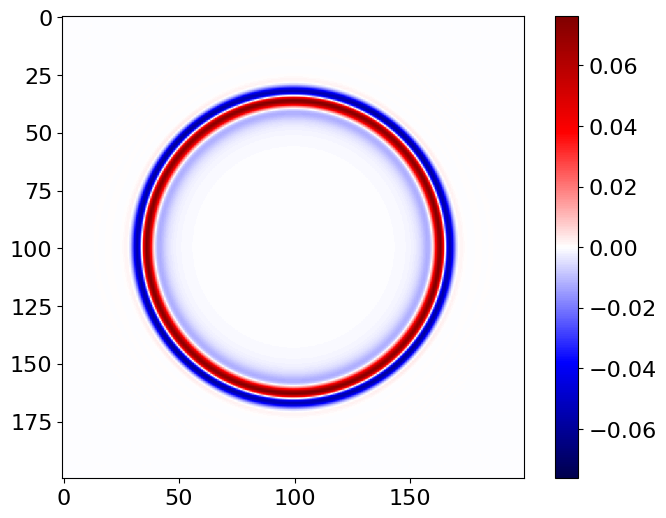

In [3]:
vmax = np.amax(np.abs(p.data[0]))
plt.imshow(p.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [4]:
extent = (200., 200.)
shape = (200, 200)

x = dv.SpaceDimension(name='x', spacing=dv.Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = dv.SpaceDimension(name='z', spacing=dv.Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))
p_s = dv.TimeFunction(name='p_s', grid=grid, space_order=4, time_order=2)

vp = 1
dt = np.amin(grid.spacing)*0.6/vp

t0 = 0
tn = 0.25*300
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src_s = RickerSource(name='src', grid=grid, f0=0.1, npoint=1, time_range=time_range)
src_s.coordinates.data[:] = [100., 100.]

pde_s = p_s.dt2 - vp**2*p_s.laplace
stencil_s = dv.Eq(p_s.forward, dv.solve(pde_s, p_s.forward))
src_p_s = src_s.inject(field=p_s.forward, expr=src_s)

op_s = dv.Operator([stencil_s] + src_p_s)

op_s(dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.008982999999999988, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.9999999999999996e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

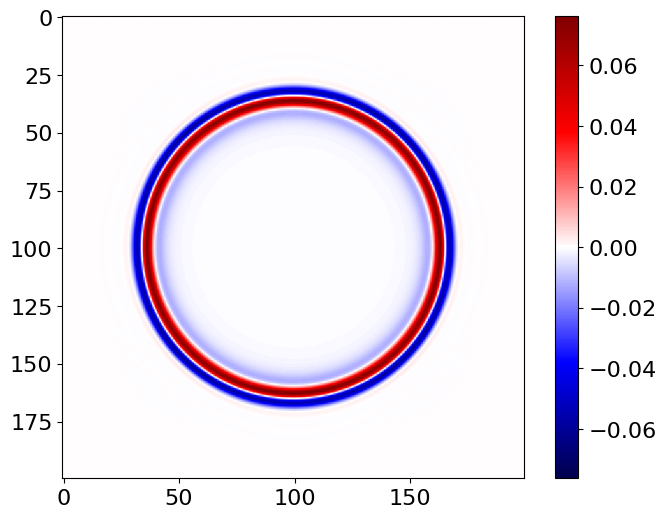

In [5]:
vmax = np.amax(np.abs(p_s.data[0]))
plt.imshow(p_s.data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

Maximum value of the difference: 1.7763232e-06
Minimum value of the difference: -7.21775e-07
Percentage change:  0.0018267992345499806 %


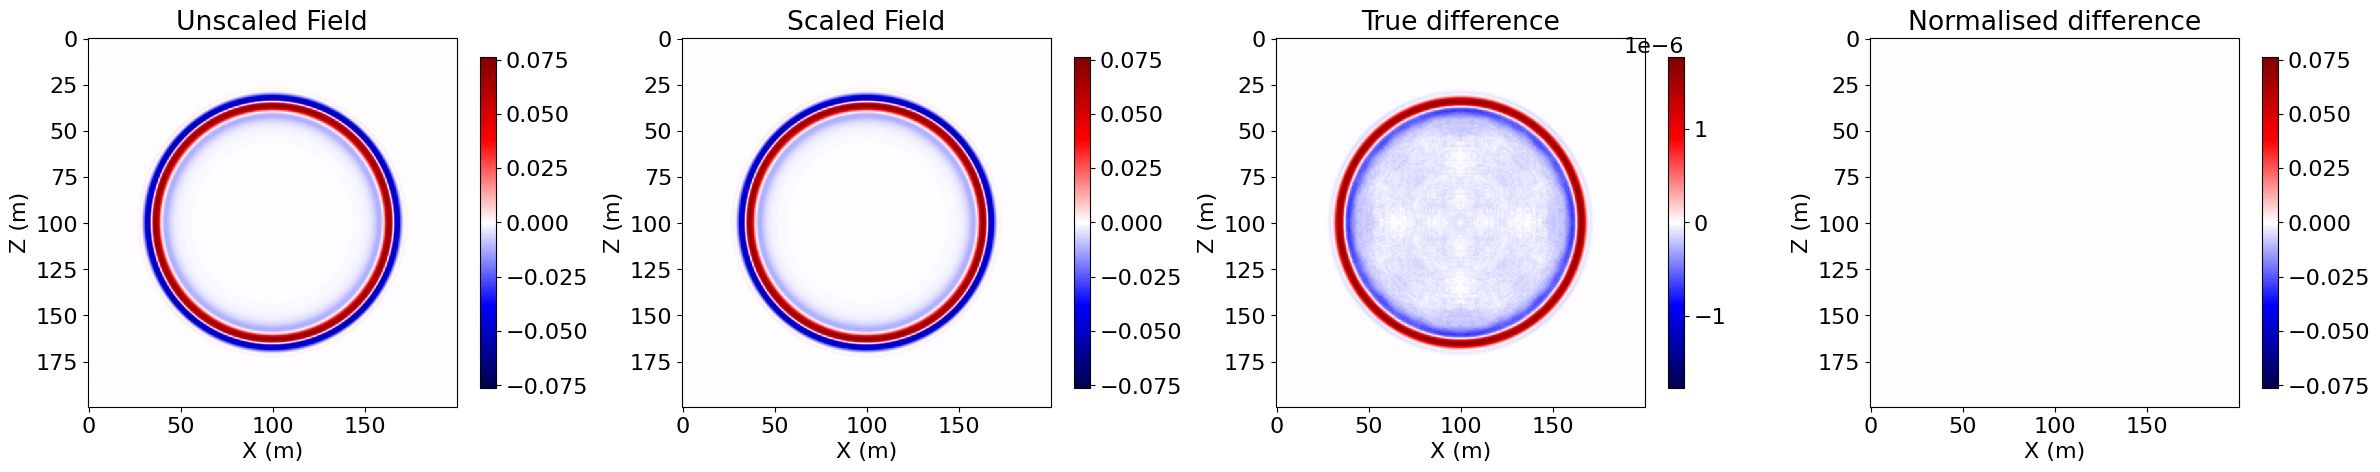

In [6]:
calculate_diff(p.data[0], p_s.data[0])

Operator `Kernel` ran in 0.06 s


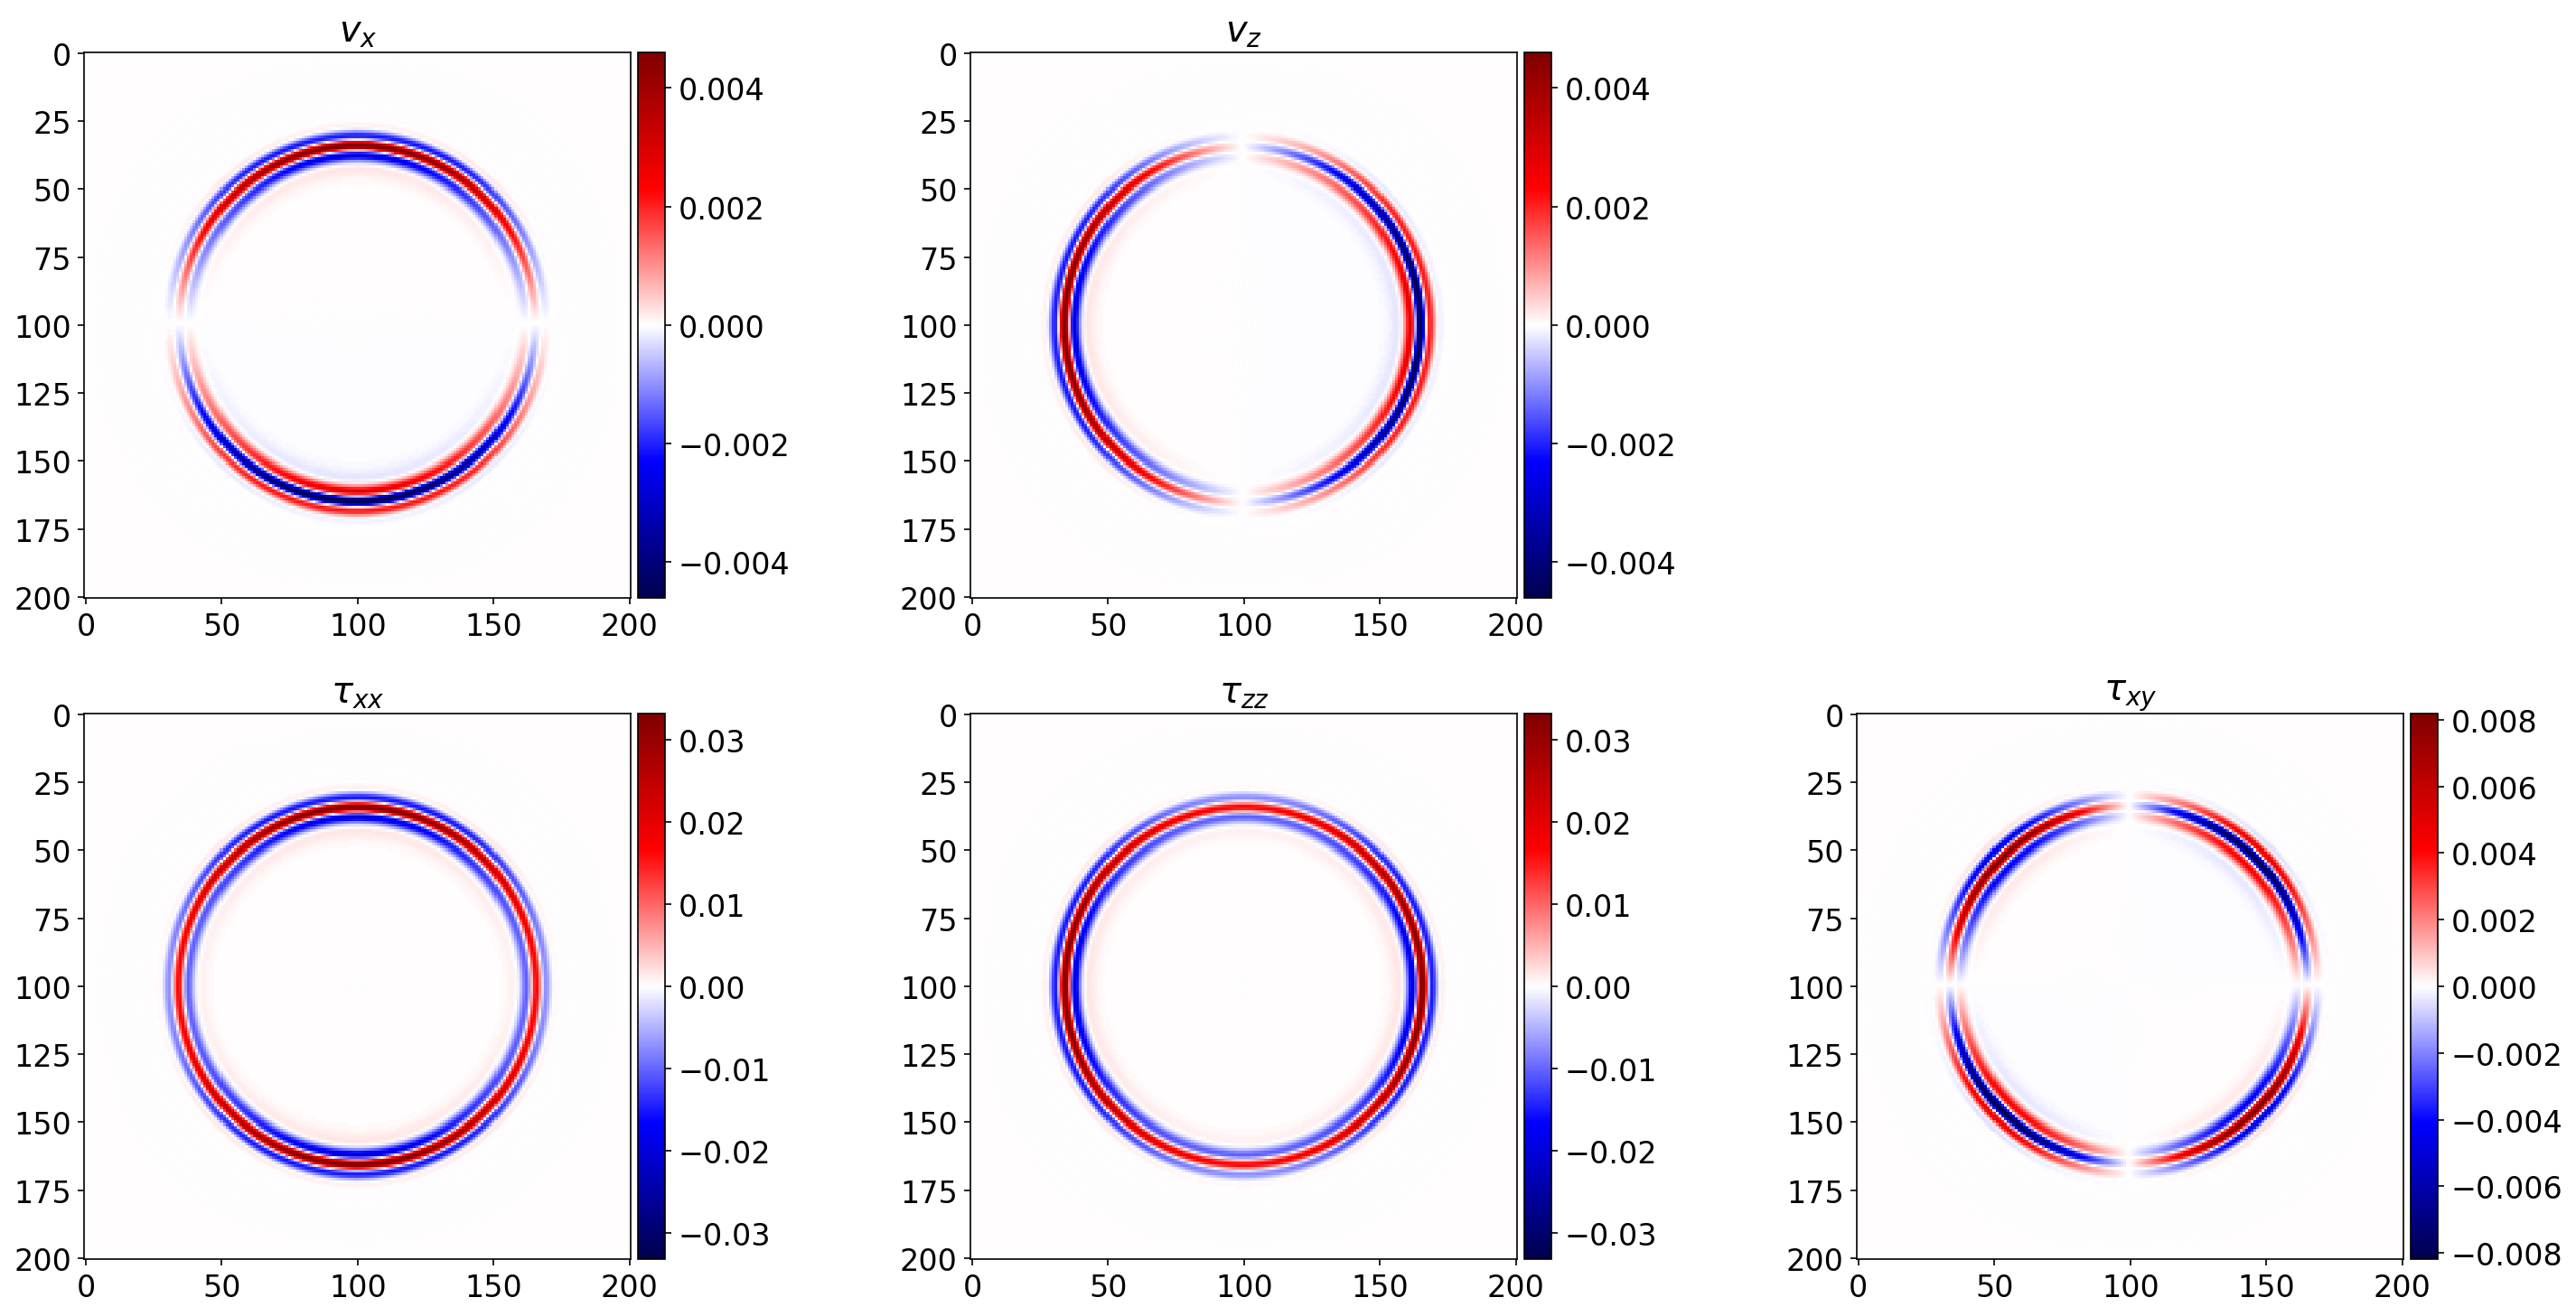

In [7]:
# Set up the grid
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# Create the velocity and stress fields
# space order 4 works best
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=4, time_order=1)
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=4, time_order=1)

# Define constants
constants = {
    "vp": 3,
    "vs": 1.5,
    "density": 2.4,
    "f0": 0.03
}

# Find dt using CFL condition
vmax = max(constants['vp'], constants['vs'])
dt = np.amin(grid.spacing) * 0.6 / vmax

# Define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Create the source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)

# Setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections
src_xx = src.inject(field=tau[0, 0].forward, expr=src)
src_zz = src.inject(field=tau[1, 1].forward, expr=src)
src_xz = src.inject(field=tau[0, 1].forward, expr=src)

# define equations
eq_v = v.dt - 1/constants["density"]*dv.div(tau)
eq_tau = tau.dt - constants["density"] * (constants["vp"]**2 - 2 * constants["vs"]**2) * dv.diag(dv.div(v.forward)) - constants["density"] * constants["vs"]**2 * (dv.grad(v.forward) + dv.grad(v.forward).transpose(inner=False))

# Define stencils
stencil_v = dv.Eq(v.forward, dv.solve(eq_v, v.forward))
stencil_tau = dv.Eq(tau.forward, dv.solve(eq_tau, tau.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v, stencil_tau] + src_xx + src_zz)
op(dt=dt)

# Data fields to display: v_x, v_z, tau_xx, tau_zz, tau_xz
fields = {
    "v_x": v[0].data[0],  # v_x field
    "v_z": v[1].data[0],  # v_z field
    "tau_xx": tau[0, 0].data[0],  # tau_xx field
    "tau_zz": tau[1, 1].data[0],  # tau_zz field
    "tau_xz": tau[0, 1].data[0]   # tau_xz field
}

titles = {
    "v_x": r"$v_{x}$",
    "v_z": r"$v_{z}$",
    "tau_xx": r"$\tau_{xx}$",
    "tau_zz": r"$\tau_{zz}$",
    "tau_xz": r"$\tau_{xy}$"
}

# Create the figure and subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=150)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Assign the fields to specific subplots
top_row_indices = [0, 1]  # Top row: 2 plots
bottom_row_indices = [3, 4, 5]  # Bottom row: 3 plots

# List of fields in desired order (top: velocities, bottom: stresses)
plot_fields = ['v_x', 'v_z', 'tau_xx', 'tau_zz', 'tau_xz']

# Plot the velocity fields on the top row
for i, field in enumerate(plot_fields[:2]):
    ax = axes[top_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Plot the stress fields on the bottom row
for i, field in enumerate(plot_fields[2:]):
    ax = axes[bottom_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Remove the empty subplot (top-right)
fig.delaxes(axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the complete figure with all subplots
plt.show()


Operator `Kernel` ran in 0.04 s


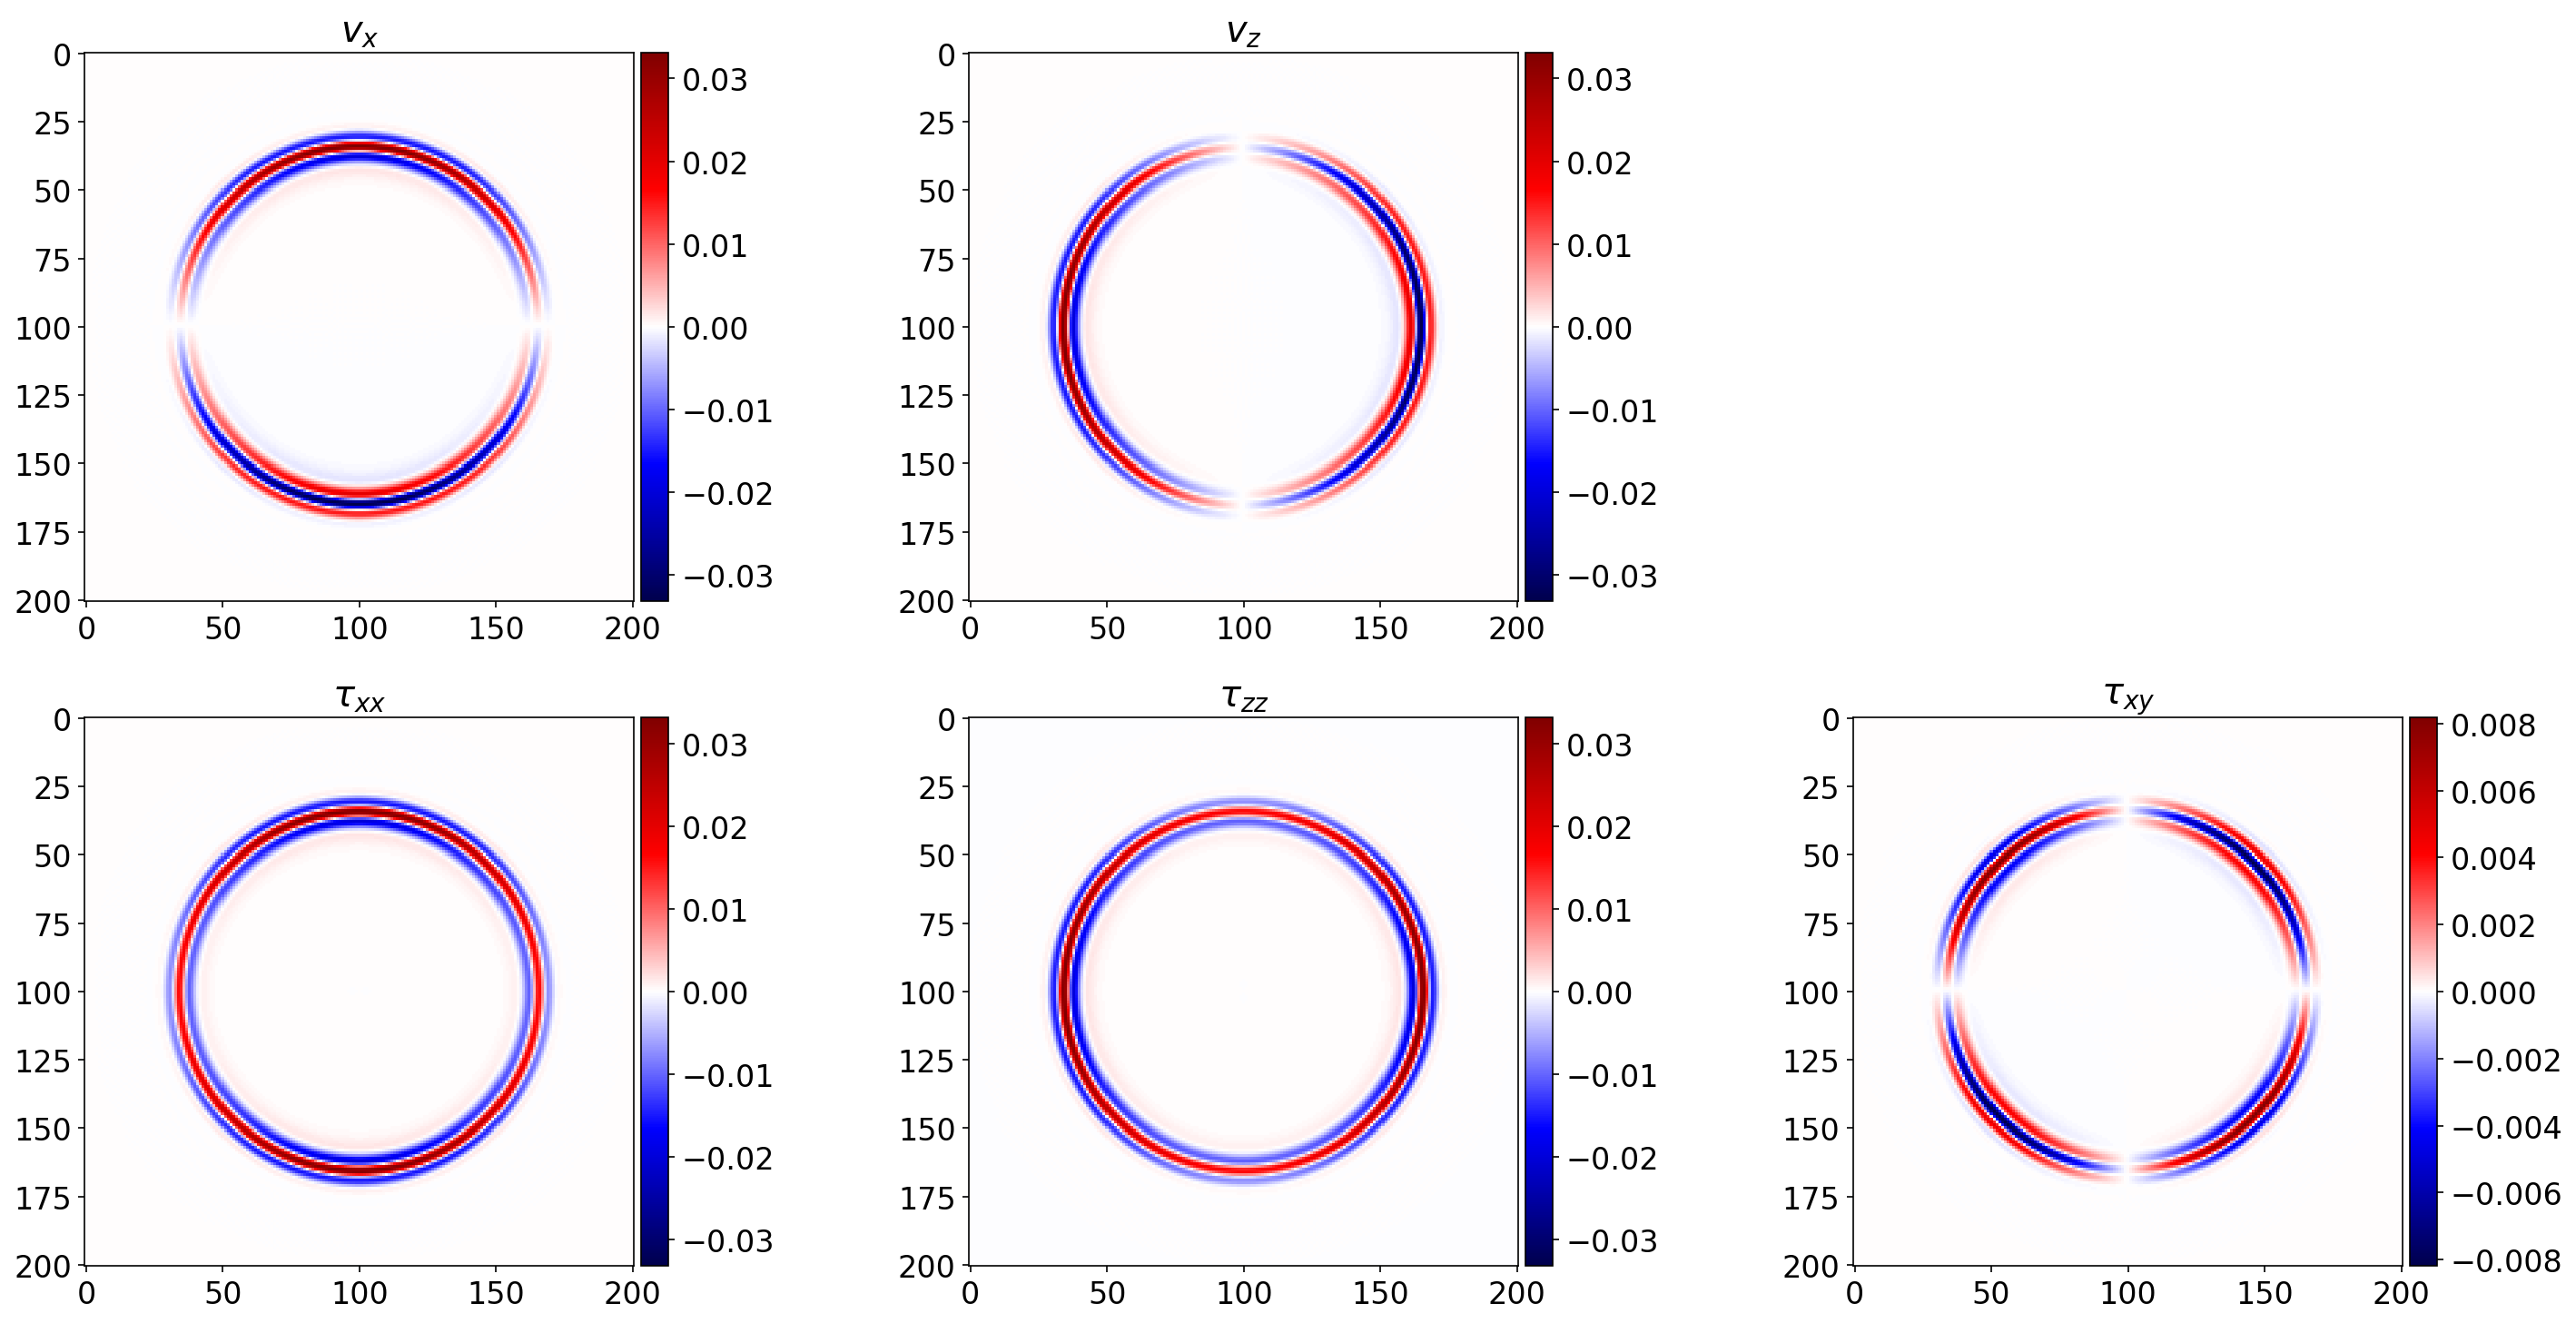

In [8]:
# Set up the grid
new_extent = (200, 200)
new_shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
new_grid = dv.Grid(extent=new_extent, shape=new_shape, dimensions=(x, z))

# Create the velocity and stress fields
# space order 4 works best
v_s = dv.VectorTimeFunction(name='v', grid=new_grid, space_order=4, time_order=1)
tau_s = dv.TensorTimeFunction(name='tau', grid=new_grid, space_order=4, time_order=1)

# Define constants with velocities in (10m)/s and density per (10m)3
constants = {
    "vp": 300,
    "vs": 150,
    "density": 2400000,
    "f0": 0.03
}

vmax = constants["vp"]
pmax = constants["density"]

# scale constants
scaled_constants = {
    "vp": 300/vmax,
    "vs": 150/vmax,
    "density": 2400000/pmax,
    "f0": 0.1
}

# Find dt using CFL condition
vmax = scaled_constants["vp"]
dt = np.amin(new_grid.spacing) * 0.6 / vmax

# Define a time range for the source term
t0 = 0
tn = 0.25*300
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Create the source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=new_grid, f0=scaled_constants["f0"], npoint=1, time_range=time_range)

# Setting source to the middle of the grid
src.coordinates.data[:] = [100., 100.]

# Source term injections
src_xx = src.inject(field=tau_s[0, 0].forward, expr=src)
src_zz = src.inject(field=tau_s[1, 1].forward, expr=src)
src_xz = src.inject(field=tau_s[0, 1].forward, expr=src)

# define equations
eq_v_s = v_s.dt - 1/scaled_constants["density"]*dv.div(tau_s)
eq_tau_s = tau_s.dt - scaled_constants["density"] * (scaled_constants["vp"]**2 - 2 * scaled_constants["vs"]**2) * dv.diag(dv.div(v_s.forward)) - scaled_constants["density"] * scaled_constants["vs"]**2 * (dv.grad(v_s.forward) + dv.grad(v_s.forward).transpose(inner=False))

# Define stencils
stencil_v = dv.Eq(v_s.forward, dv.solve(eq_v_s, v_s.forward))
stencil_tau = dv.Eq(tau_s.forward, dv.solve(eq_tau_s, tau_s.forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_v, stencil_tau] + src_xx + src_zz)
op(dt=dt)

# Data fields to display: v_x, v_z, tau_xx, tau_zz, tau_xz
fields = {
    "v_x": v_s[0].data[0],  # v_x field
    "v_z": v_s[1].data[0],  # v_z field
    "tau_xx": tau_s[0, 0].data[0],  # tau_xx field
    "tau_zz": tau_s[1, 1].data[0],  # tau_zz field
    "tau_xz": tau_s[0, 1].data[0]   # tau_xz field
}

titles = {
    "v_x": r"$v_{x}$",
    "v_z": r"$v_{z}$",
    "tau_xx": r"$\tau_{xx}$",
    "tau_zz": r"$\tau_{zz}$",
    "tau_xz": r"$\tau_{xy}$"
}

# Create the figure and subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=150)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Assign the fields to specific subplots
top_row_indices = [0, 1]  # Top row: 2 plots
bottom_row_indices = [3, 4, 5]  # Bottom row: 3 plots

# List of fields in desired order (top: velocities, bottom: stresses)
plot_fields = ['v_x', 'v_z', 'tau_xx', 'tau_zz', 'tau_xz']

# Plot the velocity fields on the top row
for i, field in enumerate(plot_fields[:2]):
    ax = axes[top_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Plot the stress fields on the bottom row
for i, field in enumerate(plot_fields[2:]):
    ax = axes[bottom_row_indices[i]]
    
    # Set vmax and vmin for color scale
    data = fields[field]
    vmax = np.amax(np.abs(data))

    # Plot the field using imshow
    im = ax.imshow(data, cmap='seismic', vmin=-vmax, vmax=vmax)

    # Create a divider for each axis to append a colorbar next to the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and padding

    # Add the colorbar to the right of the plot
    fig.colorbar(im, cax=cax)

    # Set title for each subplot
    ax.set_title(titles[field])

# Remove the empty subplot (top-right)
fig.delaxes(axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the complete figure with all subplots
plt.show()

Maximum value of the difference: 0.028572429
Minimum value of the difference: -0.028572429
Percentage change:  620.0010776519775 %


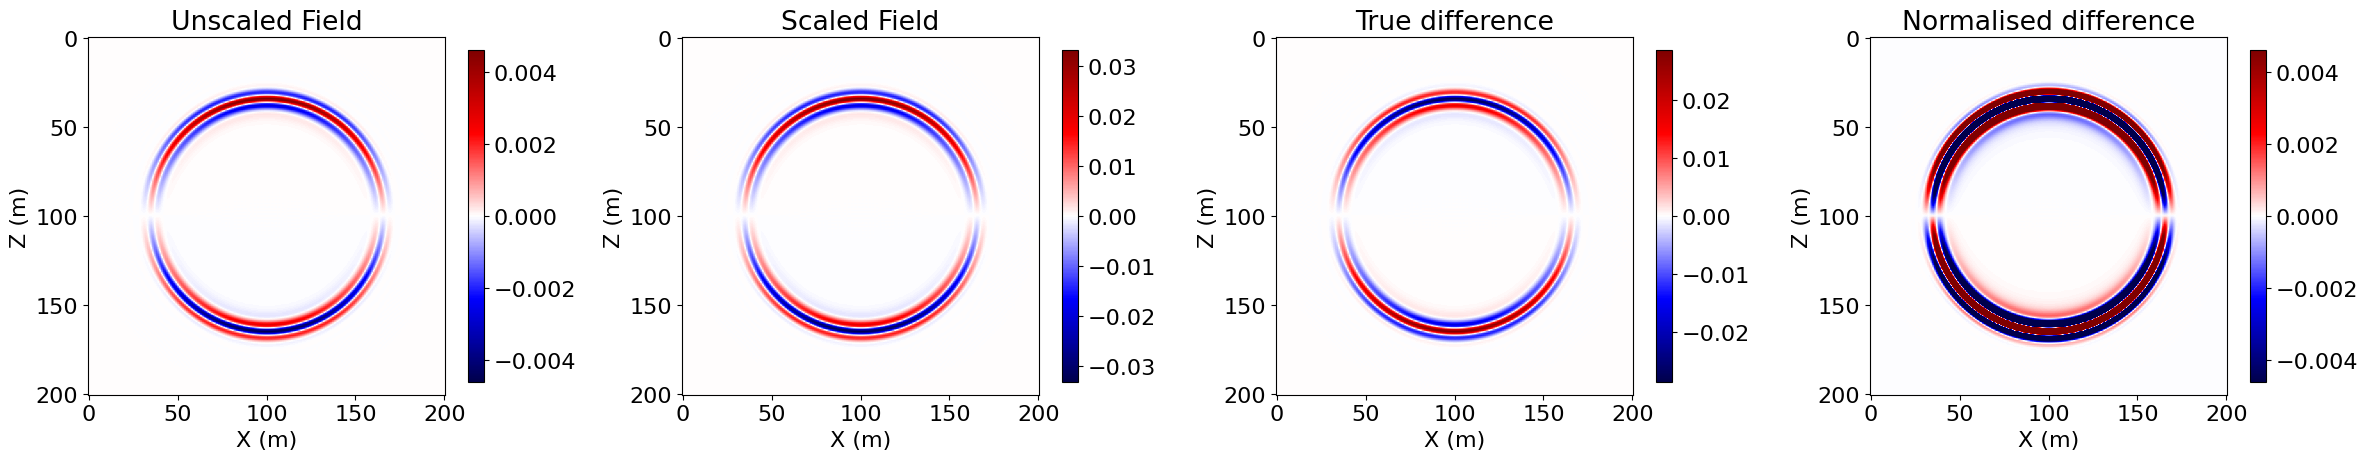

In [9]:
calculate_diff(v[0].data[0], v_s[0].data[0])

Maximum value of the difference: 2.2118911e-08
Minimum value of the difference: -2.2118911e-08
Percentage change:  0.00026977302240993595 %


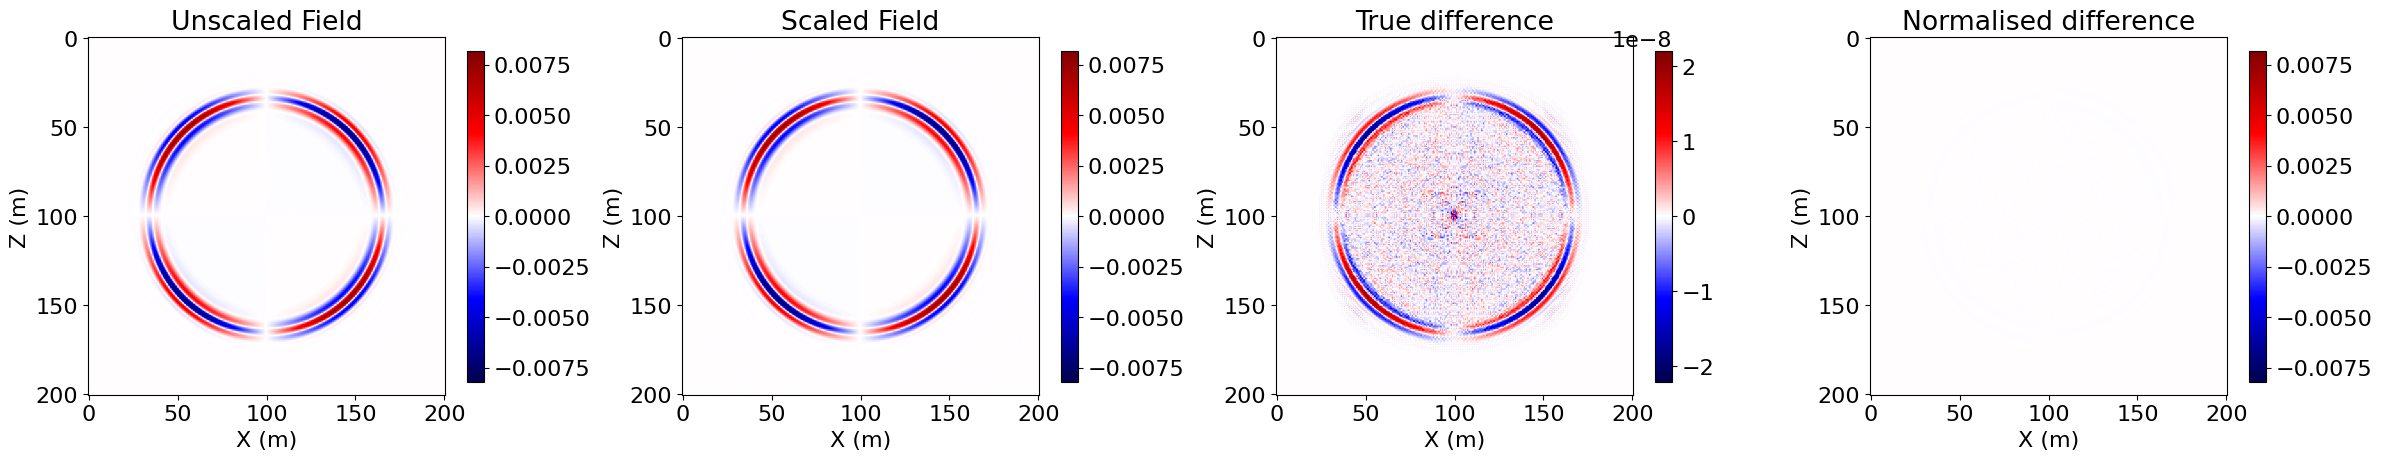

In [10]:
calculate_diff(tau[0, 1].data[0], tau_s[0, 1].data[0])